## Modelling

Tasks:
- Build a model to predict the malignant tumors.
- Use at least two classification techniques; compare and contrast the advantages and disadvantages of each.
- Identify how we would control for overfitting in each classification technique.
- Evaluate the performance of each model.
- In each model, identify the most important predictive variables and explain how we identified them.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

import helper
import pandas as pd

Let's load the data to select best features to distinguish two classes (`B` and `M`) with the same preprocessing as in the previous notebook

In [2]:
data = helper.load_data()
classes = data["diagnosis"].astype('category')

df = data.drop(['ID', 'diagnosis'], axis=1)
#select_features requires non-negative values
normalized_values = preprocessing.normalize(df)
normalized_df = pd.DataFrame(normalized_values, columns=df.columns)

selected_features = helper.select_features(normalized_df, classes)
selected_features

Index(['radius_worst', 'concave_points_mean', 'concave_points_sd_error'], dtype='object')

Since the data distributed by normal-like distribution, we can use `StandartScaler`

In [3]:
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data[selected_features])
df = pd.DataFrame(scaled_data, columns=selected_features)
df['diagnosis'] = data.diagnosis
display(df.head(2))

,radius_worst,concave_points_mean,concave_points_sd_error,diagnosis
0,1.269934,-1.359293,2.303601,M
1,1.685955,-0.369203,1.535126,M


We'll use bootstrap samples to inflate the dataset

<AxesSubplot:title={'center':'radius_worst'}, xlabel='diagnosis'>

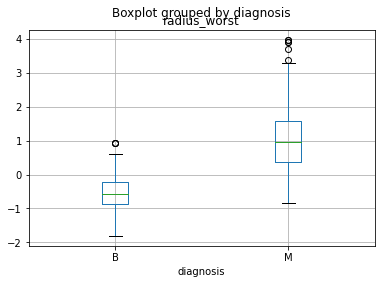

In [4]:
dataset = helper.bootstrap_df(df, 1000)   
dataset.boxplot(selected_features[0], 'diagnosis')

In [5]:
classes = dataset["diagnosis"].apply(lambda x: 1 if x == 'M' else 0)
x = dataset.drop('diagnosis', axis=1)
display(x.head(2))

,radius_worst,concave_points_mean,concave_points_sd_error
168,0.993959,1.083363,1.430876
527,-0.536668,-1.043377,-0.596944


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, classes, test_size=0.2, random_state=0)
print(f'{len(x_train)} train samples, {len(x_test)} test samples')
display(y_test.value_counts())

800 train samples, 200 test samples


0    117
1     83
Name: diagnosis, dtype: int64

The first algorithm is C-Support Vector Classification implemented in sklearn. It can be used for an unbalanced dataset and allows adjusting C parameter to prevent overfitting (As we increase the value, we prefer more accurate separating of points to the larger gap between them, which raises chances to overfit the data). For choosing an optimal value, we should test it on different data samples (cross-validation). We'll set linear kernel (it also can prevent overfitting)

In [7]:
clf = SVC(C=4, kernel='linear') #chose C=4, based on several runs
clf.fit(x_train, y_train)

preds = clf.predict(x_test)

print("SVC accuracy")
print("- train data:", clf.score(x_train, y_train)) 
print("- test data:", clf.score(x_test, y_test)) 
print("tn, fp, fn, tp - True benign, False malignant, False benign, True malignant")#negative=benign, positive=malignant
cm = confusion_matrix(y_true=y_test, y_pred=preds)
print(cm.ravel())

tn, fp, fn, tp = cm.ravel()
print(f'{fp+fn} samples are mispredicted')

SVC accuracy
- train data: 0.9525
- test data: 0.975
tn, fp, fn, tp - True benign, False malignant, False benign, True malignant
[115   2   3  80]
5 samples are mispredicted


In [8]:
print('False negative rate:', fn/(fp+tn))
print('False positive rate:', fp/(fn+tp))

print('f1-score =', tp/(tp + (fp+fn)/2))
print('precision =', tp/(tp + fp))
print('recall =', tp/(tp + fn))

False negative rate: 0.02564102564102564
False positive rate: 0.024096385542168676
f1-score = 0.9696969696969697
precision = 0.975609756097561
recall = 0.963855421686747


The next algorithm is K-Nearest Neighbors Classifier implemented in sklearn as well. It allows adjusting the n_neighbors parameter to prevent overfitting (As we increase the number of neighbors, we increase accuracy; to high value make the model overfit)

In [9]:
clf = KNeighborsClassifier(n_neighbors=4) #chose n_neighbors=4, based on several runs
clf.fit(x_train, y_train)

preds = clf.predict(x_test)

print("K-Neighbors Classifier accuracy")
print("- train data:", clf.score(x_train, y_train)) 
print("- test data:", clf.score(x_test, y_test)) 
print("tn, fp, fn, tp - True benign, False malignant, False benign, True malignant")#negative=benign, positive=malignant
cm = confusion_matrix(y_true=y_test, y_pred=preds)
print(cm.ravel())

tn, fp, fn, tp = cm.ravel()
print(f'{fp+fn} samples are mispredicted')

K-Neighbors Classifier accuracy
- train data: 0.9725
- test data: 0.96
tn, fp, fn, tp - True benign, False malignant, False benign, True malignant
[117   0   8  75]
8 samples are mispredicted


In [10]:
print('False negative rate:', fn/(fp+tn))
print('False positive rate:', fp/(fn+tp))

print('f1-score =', tp/(tp + (fp+fn)/2))
print('precision =', tp/(tp + fp))
print('recall =', tp/(tp + fn))

False negative rate: 0.06837606837606838
False positive rate: 0.0
f1-score = 0.9493670886075949
precision = 1.0
recall = 0.9036144578313253


- It must be said, that accuracy depends on data sampling and splitting. To get different results, change random seeds in parameters of data sampling and splitting functions. Bootstrapping more data may increase accuracy as well.
- In this case, SVC gave better results, as potentially more patients who need treatment get it. But it may differ from sample to samle
- We should provide cross-validation to adjust the parameters and choose the most optimal for the problem algorithm. Optimality can be estimated using accuracy, f1-score, number of tp, tn, fn, fp and other statistical metrics

# Explanation

## To Technical Audiences

On the current data sampling:

SVC: f1-score=0.970, false negative rate = 0.026, false positive rate: 0.024

KNN: f1-score=0.950, false negative rate = 0.068, false positive rate: 0.0

The further steps:

Provide more tests on:
    - balanced data (use class weights)
    - different hyperparameters

The dataset is relatively small, crossvalidation might be necessary.
    

## To Non-Technical Audiences

- We trained and compared two machine learning algorithms.
- The trained model gets a datapoint and predicts to which group the record belongs to: malignant or benign. 
- Even though it seems both classifiers show similar accuracy, the results actually differ from each other.
- KNN predicted all benign tumors, but gave 8 wrong diagnoses for malignant tumors.
- SVC mispredicted less malignant records (3 < 8).
- Using these algorithms we are able to achieve 95% of true predictions and probably increase the accuracy by adjusting initial data and algorithms' parameters.